In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
mkdir ~/.kaggle

In [3]:
cd ~/.kaggle

/root/.kaggle


In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
ls -al

total 16
drwxr-xr-x 2 root root 4096 Jun 12 17:48 ./
drwx------ 1 root root 4096 Jun 12 17:48 ../
-rw-r--r-- 1 root root   68 Jun 12 17:48 kaggle.json


In [6]:
cd /content/gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [7]:
ls -al

total 13374
-rw------- 1 root root     5568 Mar 19 06:56  assignment_week3.ipynb
-rw------- 1 root root 10197784 Jun 12 09:19  best_model.h5
-rw------- 1 root root    42954 May 28 05:15  chap8.ipynb
-rw------- 1 root root   128771 Oct 22  2023 'Colaboratory에 오신 것을 환영합니다의 사본'
-rw------- 1 root root   128771 Oct 22  2023 'Colaboratory에 오신 것을 환영합니다의 사본 (1)'
drwx------ 2 root root     4096 Apr  2 05:13  covid19/
drwx------ 2 root root     4096 May 28 02:49  ecg/
-rw------- 1 root root   249293 Jun 12 09:42  finalProject.ipynb
drwx------ 2 root root     4096 Apr  2 04:49  .ipynb_checkpoints/
-rw------- 1 root root       68 Jun 11 02:21 'kaggle (1).json'
-rw------- 1 root root       68 Jun  4 05:35  kaggle.json
drwx------ 2 root root     4096 May 28 05:11  pknu-deep-learning-2024/
drwx------ 2 root root     4096 May 24 10:01  svc2004/
-rw------- 1 root root     5413 Jun 12 09:42  test_predict.csv
drwx------ 2 root root     4096 Apr  2 04:49  titanic/
-

In [8]:
ls '/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/rowdata/rowdata/Train' | wc -l

800


In [9]:
folderpath = '/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/rowdata/rowdata'

In [10]:
import random
import tensorflow as tf
seed_num = 71
random.seed(seed_num)

In [11]:
import numpy as np
import os


# 파라미터로 학습 및 테스트 폴더의 모든 서명 데이터를 읽고
#전체 서명의 길이 중 가장 긴 길이의 값을 반환
def get_max_len(folderpath_train, folderpath_test):
  n_max_len = 0
  for filename in os.listdir(folderpath_train):
    filepath = f'{folderpath_train}/{filename}'
    d, tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  for filename in os.listdir(folderpath_test):
    filepath = f'{folderpath_test}/{filename}'
    d,tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  return n_max_len

# 파라미터로 주어진 폴더에 들어 있는 서명 파일 전체를 읽고,
#n_files * n_max_len * 2 크기의 numpy 배열로 만들어 반환
# 파라미터 n_max_len은 전체 서명 데이터들 중 가장 긴 서며야의 길이를 의미

# 데이터와 함께 반환하는 len_sign 는 각 서명의 실제 길이를 의미

def load_data(folderpath, n_max_len, sig_ids):
  filelist = os.listdir(folderpath)
  n_files = len(filelist)
  d = np.zeros((n_files, n_max_len,2))

  len_sign = np.zeros(n_files)

  for i in sig_ids:
    filepath = f'{folderpath}/{i}.TXT'
    d_tmp, len_sign[i-sig_ids[0]] = load_a_sig(filepath)

    d[i-sig_ids[0],:d_tmp.shape[0],:] = d_tmp
  return d,len_sign


# 파라미터로 주어진 서명 파일을 읽고, nPoint * 2 크기의 numpy 배열로 만들어 반환

def load_a_sig(filepath):
  f = open(filepath,'rt')
  nPoints = int(f.readline())

  d = np.zeros((nPoints,2))
  for i in range(nPoints):
    line = f.readline()
    toks = line.split(' ')
    d[i,:] = [int(toks[0]), int(toks[1])]
  f.close()
  return d, nPoints

In [12]:
n_train = 800
n_test = 800

n_max_len = get_max_len(f'{folderpath}/Train', f'{folderpath}/Test')

x_train, x_train_len = load_data(f'{folderpath}/Train', n_max_len,range(n_train))

x_test, x_test_len = load_data(f'{folderpath}/Test', n_max_len, range(n_train,1600))

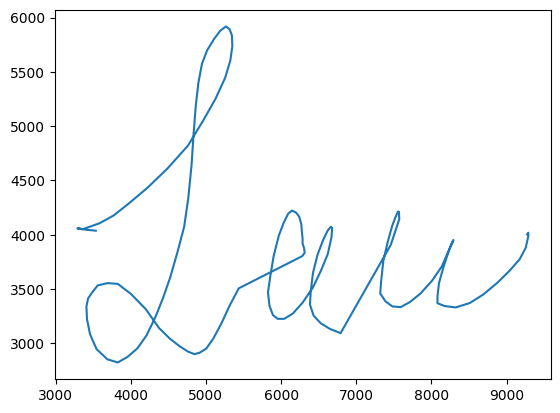

In [13]:
import matplotlib.pyplot as plt
s_id = 10
len_sig = int(x_train_len[s_id])
plt.plot(x_train[s_id,:len_sig,0], x_train[s_id, :len_sig,1])

In [14]:
for i in range(x_train.shape[0]):
  len_tmp = int(x_train_len[i])
  h_min = np.min(x_train[i,:len_tmp,0])
  h_max = np.max(x_train[i,:len_tmp,0])
  v_min = np.min(x_train[i,:len_tmp,1])
  v_max = np.max(x_train[i,:len_tmp,1])
  w_h_ratio = (v_max - v_min) / (h_max - h_min)
  x_train[i,:len_tmp,0] = (x_train[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_train[i,:len_tmp,1] = (x_train[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio

for i in range(x_test.shape[0]):
  len_tmp = int(x_test_len[i])
  h_min = np.min(x_test[i,:len_tmp,0])
  h_max = np.max(x_test[i,:len_tmp,0])
  v_min = np.min(x_test[i,:len_tmp,1])
  v_max = np.max(x_test[i,:len_tmp,1])

  w_h_ratio = (v_max - v_min) / (h_max - h_min)

  x_test[i,:len_tmp,0] = (x_test[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_test[i,:len_tmp,1] = (x_test[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio


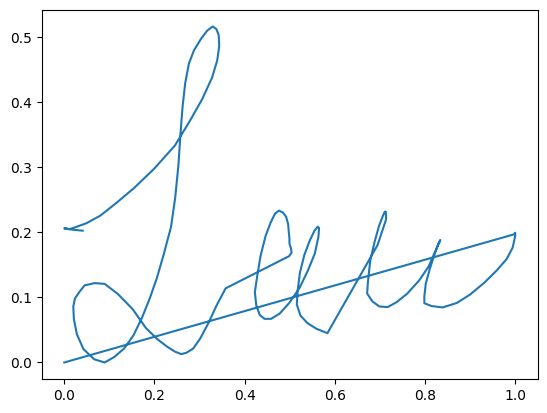

In [15]:
import matplotlib.pyplot as plt
s_id = 10
plt.plot(x_train[s_id,:,0],x_train[s_id,:,1])

In [16]:
import pandas as pd
from tensorflow import keras

y_pd = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/train_info.csv')
y_all = np.array(y_pd['bGenuine'])
y_train = y_all[:n_train]
y_train_cat = keras.utils.to_categorical(y_train)
# y_test = y_all[:n_train]


In [82]:
from keras.layers import *
from keras.models import Model
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2

# Define a function to reduce the learning rate at specific intervals
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 200:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 100:
        lr *= 1e-2
    elif epoch > 50:
        lr *= 1e-1
    return lr

model = Sequential()
model.add(Conv1D(32, kernel_size=7, padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=7, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax', kernel_regularizer=l2(0.001)))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Adding ModelCheckpoint and LearningRateScheduler callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_scheduler = LearningRateScheduler(lr_schedule)

hist = model.fit(x=x_train, y=y_train_cat, epochs=300, validation_split=0.3, batch_size=32, callbacks=[checkpoint, lr_scheduler])

Epoch 1/300
17/18 [===========================>..] - ETA: 0s - loss: 2.0886 - accuracy: 0.5165
Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 14s 157ms/step - loss: 2.0864 - accuracy: 0.5161 - val_loss: 1.9971 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 2/300
17/18 [===========================>..] - ETA: 0s - loss: 1.9429 - accuracy: 0.5772
Epoch 2: val_accuracy did not improve from 0.52500
18/18 [==============================] - 1s 34ms/step - loss: 1.9450 - accuracy: 0.5750 - val_loss: 1.9017 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 3/300
17/18 [===========================>..] - ETA: 0s - loss: 1.8509 - accuracy: 0.5864
Epoch 3: val_accuracy did not improve from 0.52500
18/18 [==============================] - 1s 36ms/step - loss: 1.8446 - accuracy: 0.5911 - val_loss: 1.8115 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 4/300
17/18 [===========================>..] - ETA: 0s - loss: 1.7384 - accuracy: 0.6250
Epoch 4: val_accuracy did not improve from 0.52500
18/18 [==============================] - 1s 32ms/step - loss: 1.7391 - accuracy: 0.6214 - val_loss: 1.7509 - val_accuracy: 0.5250 -

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

def drawHistory(hist) :

  # hist.history를 데이터프레임으로 변환
  history_df = pd.DataFrame(hist.history)

  # 데이터프레임을 표로 출력
  print(history_df)

  # 데이터프레임을 시각화 (옵션)
  plt.figure(figsize=(12, 6))

  # 훈련 손실과 검증 손실 그래프
  plt.subplot(1, 2, 1)
  plt.plot(history_df['loss'], label='Training Loss')
  plt.plot(history_df['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # 훈련 정확도와 검증 정확도 그래프
  plt.subplot(1, 2, 2)
  plt.plot(history_df['accuracy'], label='Training Accuracy')
  plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

plt.show()



         loss  accuracy  val_loss  val_accuracy            lr
0    2.086360  0.516071  1.997109      0.525000  1.000000e-03
1    1.944983  0.575000  1.901712      0.525000  1.000000e-03
2    1.844640  0.591071  1.811493      0.525000  1.000000e-03
3    1.739085  0.621429  1.750945      0.525000  1.000000e-03
4    1.640183  0.632143  1.690078      0.525000  1.000000e-03
..        ...       ...       ...           ...           ...
295  0.258574  1.000000  0.718169      0.920833  5.000000e-07
296  0.258727  1.000000  0.717998      0.920833  5.000000e-07
297  0.258610  1.000000  0.718260      0.920833  5.000000e-07
298  0.258606  1.000000  0.718370      0.920833  5.000000e-07
299  0.258462  1.000000  0.717953      0.920833  5.000000e-07

[300 rows x 5 columns]


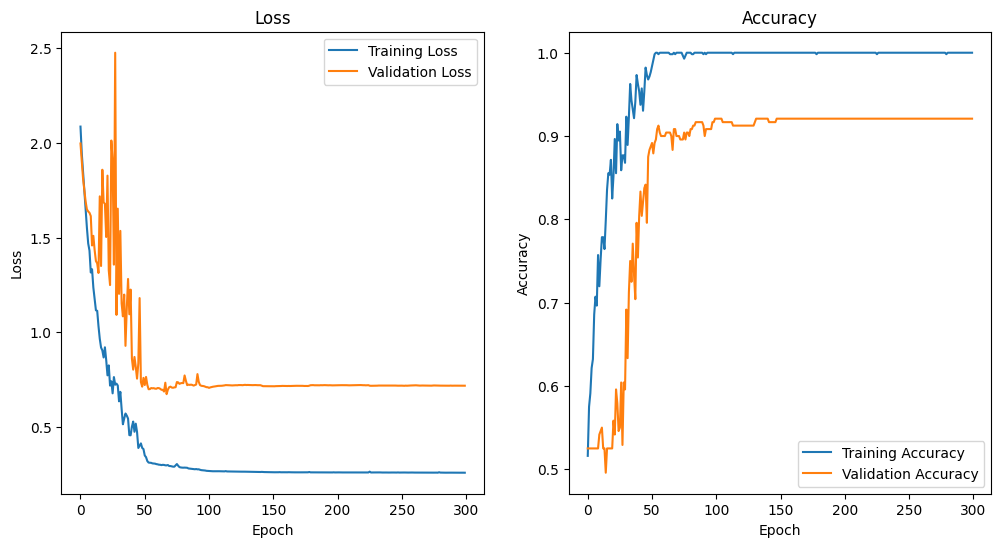

In [84]:
drawHistory(hist)

In [85]:
o = model.predict(x_test)

25/25 [==============================] - 2s 13ms/step


In [86]:
o = np.argmax(o,1)

In [87]:
df = pd.DataFrame(o)
df.columns = ['bGenuine']
df.index = range(800, 800+len(df))
df.index.name = 'num'
print(df)
df.to_csv('test_predict.csv')

      bGenuine
num           
800          1
801          1
802          1
803          0
804          0
...        ...
1595         0
1596         1
1597         0
1598         0
1599         1

[800 rows x 1 columns]


In [88]:
!kaggle competitions submit -c pknu-deep-learning-2024 -f test_predict.csv -m "Message"

100% 5.29k/5.29k [00:00<00:00, 12.9kB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (20) today, please try again tomorrow UTC (5.0 hours from now).


In [ ]:
cp finalProject.ipynb /content/gdrive/MyDrive/colab_repo_for_deep_learning/finalProject.ipynb

In [ ]:
cd ../colab_repo_for_deep_learning/

In [ ]:
!git config --global user.email "wkdghdwns199@naver.com"

In [ ]:
!git add *

In [ ]:
!git commit -m "commit"

In [ ]:
!git config --global user.name "Jang Hong Joon"

In [ ]:
!git push origin main